**Datasets can be downloaded from https://www.dropbox.com/sh/dfqht1ob89ku99d/AACI5ZW3aRuq9MhBfSNS_1O_a?dl=0**  
Ref: Nestorowa, S. et al. A single-cell resolution map of mouse hematopoietic stem and progenitor cell differentiation. Blood 128, e20-31 (2016).

From `STREAM V4.0`, some changes of default function setting have been made to enable STREAM analysis to be faster and more scalable. This tutorial is only used to reproduce the results in STREAM paper.

In [1]:
%matplotlib inline

In [2]:
import stream as st

In [3]:
st.__version__

'0.4.1'

### Read in data

In [4]:
adata=st.read(file_name='./data_Nestorowa.tsv.gz',workdir='./stream_result')

Saving results in: ./stream_result


To load and use 10x Genomics single cell RNA-seq data processed with Cell Ranger:  
(Make sure **'genes.tsv'** and **'barcodes.tsv'** are under the same folder as **'matrix.mtx'**)  

```python
adata=st.read(file_name='./filtered_gene_bc_matrices/hg19/matrix.mtx',file_format='mtx')
```

To change working directory:
```python
st.set_workdir(adata,'./stream_result_new')
```

#### read in cell labels and label color

if cell label file or cell color file is not provided, please simply run:

'unknown' will be added as the default label for all cells  
`st.add_cell_labels(adata)`

'random color will be generated for each cell label  
`st.add_cell_colors(adata)`

In [5]:
st.add_cell_labels(adata,file_name='./cell_label.tsv.gz')
st.add_cell_colors(adata,file_name='./cell_label_color.tsv.gz')

From `STREAM v4.0`, alternatively, the step can be combined into one step:
```python
st.add_metadata(adata,file_name='./metadata.tsv')
```

#### other useful preprocessing steps when dealing with raw-count data

Normalize gene expression based on library size  
`st.normalize_per_cell(adata)`

Logarithmize gene expression  
`st.log_transform(adata)` 

Remove mitochondrial genes  
`st.remove_mt_genes(adata)`

Filter out cells  
`st.filter_cells(adata)` 

Filter out genes

In [6]:
st.filter_genes(adata,min_num_cells = 5)

Filter genes based on min_num_cells
After filtering out low-expressed genes: 
1656 cells, 4762 genes


**check parameters**  
`st.select_variable_genes?`

Please check if the blue curve fits the points well.  
If not, please adjust the parameter **'loess_frac'** (By default, `loess_frac=0.01`) until the blue curve fits well.   

239 variable genes are selected


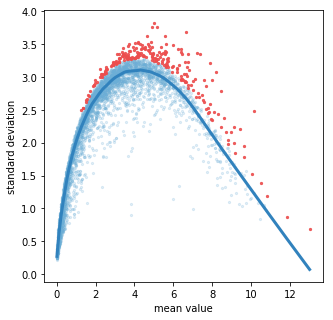

In [7]:
st.select_variable_genes(adata,loess_frac=0.1)

**Note: Alternatively, user can also select top  principal components using all genes or variable genes:**
- use all genes   
`st.select_top_principal_components(adata,n_pc=15,first_pc=True)`
- use variable genes   
    - users need to first run `st.select_variable_genes(adata,loess_frac=0.01, n_genes=2000)`  
    - `st.select_top_principal_components(adata,feature='var_genes',n_pc=15,first_pc=True)`

**check parameters**  
`st.dimension_reduction?`

Tips:

>by default `n_components =3`  
For biological process with simple bifurcation or linear trajectory, two components would be recommended  
e.g, `st.dimension_reduction(adata,n_components =2)`

>Several alternative dimension reduction methods are also supported, `mlle`(modified locally linear embedding),`se`(spectral embedding), `umap`, `pca`. From `STREAM v4.0`, by default, `method ='se'`.  
- For **large dataset**, `se`(Spectral Embedding) works faster than MLLE while preserving the similar compact structure to **MLLE**.  
e.g. `st.dimension_reduction(adata,method ='se')`

From `STREAM v4.0`, the parameter `nb_pct` (the percentage of neighbor cells) will be deprecated. Instead, please use `n_neighbors` (the number of neighbor cells). 

In [8]:
st.dimension_reduction(adata,method='mlle',nb_pct=0.1,n_components=3,n_jobs=4)

feature var_genes is being used ...
4 cpus are being used ...


> Alternatively, using top principal components as features:
`st.dimension_reduction(adata,method='se',feature='top_pcs',n_neighbors=30, n_components=3)`

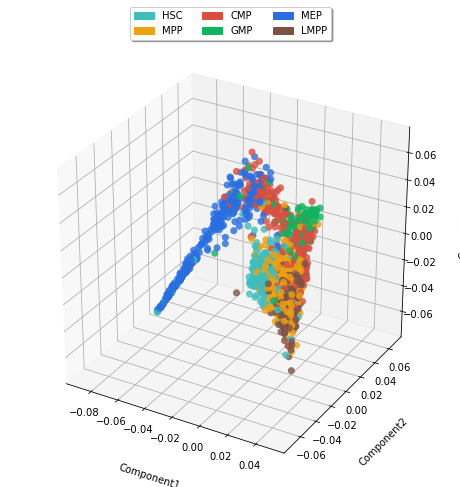

In [9]:
st.plot_dimension_reduction(adata)

**check parameters**  
`st.plot_visualization_2D?`

Tips:  
> Before the downstream **elastic principal graph learning**, it is important to visualize the top components in 2D plane with **UMAP** (by default) or **tSNE**(`st.plot_visualization_2D(adata,method='tsne')`) to confirm the existence of meaningful biological trajectory pattern 

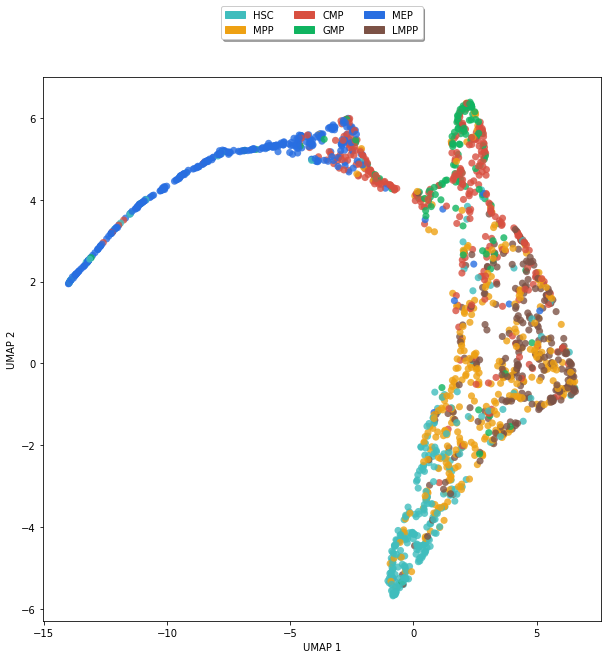

In [10]:
st.plot_visualization_2D(adata,nb_pct=0.1)

**check parameters**  
`st.seed_elastic_principal_graph?`

Tips:
>To better scale up STREAM to large datasets, since **version 0.3.8**, the default **clustering method** has been changed from **'ap'** (affinity propagation) to **'kmeans'**. Users can specify `clustering = 'ap'` to reproduce the analyses in STREAM paper:  
i.e. `st.seed_elastic_principal_graph(adata,clustering='ap')`

>If cells form a big bulk in MLLE space, **'ap'** may generate too many branches.   
In that case, try `clustering = 'kmeans'` or `clustering = 'sc'` to avoid a too complex initial strcuture

>For noisy dataset, **spectral clustering** is proved to work better to get rid of noisy branches  
e.g. `st.seed_elastic_principal_graph(adata,clustering='sc',n_clusters=10)`

In [11]:
st.seed_elastic_principal_graph(adata)

Seeding initial elastic principal graph...
Clustering...
K-Means clustering ...
The number of initial nodes is 10
Calculatng minimum spanning tree...
Number of initial branches: 3


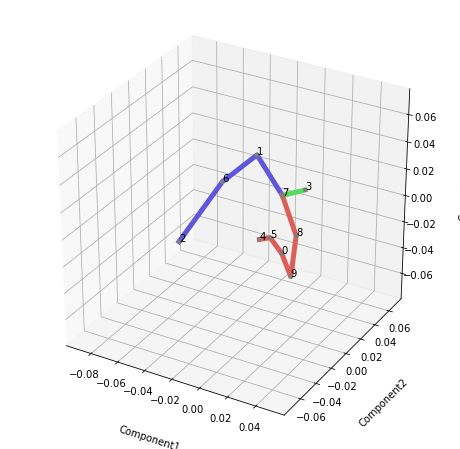

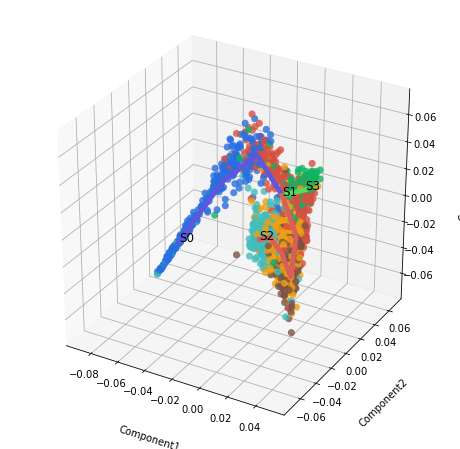

In [12]:
st.plot_branches(adata)
st.plot_branches_with_cells(adata,fig_legend=False)

**check parameters**  
`st.elastic_principal_graph?`

> `epg_alpha`, `epg_mu`, `epg_lambda` are the three most influential parameters for learning elastic principal graph.  
- `epg_alpha`: penalizes spurious branching events. **The larger, the fewer branches the function will learn**. (by default, `epg_alpha=0.02`)
- `epg_mu`: penalizes the deviation from harmonic embedding, where harmonicity assumes that each node is the mean of its neighbor nodes. **The larger, the more edges the function will use to fit into points(cells)** (by default, `epg_mu=0.1`) 
- `epg_lambda`: penalizes the total length of edges. **The larger, the 'shorter' curves the function will use to fit into points(cells)** and the fewer points(cells) the curves will reach. (by default, `epg_lambda=0.02`)

Tips:  

- Add **'epg_trimmingradius'** can help get rid of noisy points (by defalut `epg_trimmingradius=Inf`)   
e.g. `st.elastic_principal_graph(adata,epg_trimmingradius=0.1)`  

In [13]:
st.elastic_principal_graph(adata,epg_alpha=0.02,epg_mu=0.1,epg_lambda=0.02)

Learning elastic principal graph...
[1]
 "Constructing tree 1 of 1 / Subset 1 of 1"


[1]
 "Computing EPG with 50 nodes on 1656 points and 3 dimensions"


[1]
 "Using a single core"


Nodes = 
10
 
11
 
12
 
13
 
14
 
15
 
16
 
17
 
18
 
19
 
20
 
21
 
22
 
23
 
24
 
25
 
26
 
27
 
28
 
29
 
30
 
31
 
32
 
33
 
34
 
35
 
36
 
37
 
38
 
39
 
40
 
41
 
42
 
43
 
44
 
45
 
46
 
47
 
48
 
49
 


BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

2||50
	
0.0001097
	
50
	
49
	
44
	
2
	
0
	
0
	
6.533e-05
	
6.253e-05
	
0.964
	
0.9655
	
3.93e-05
	
5.071e-06
	
0.0002536
	
0.01268
	
0


9.719 sec elapsed

[[1]]



Number of branches after learning elastic principal graph: 5


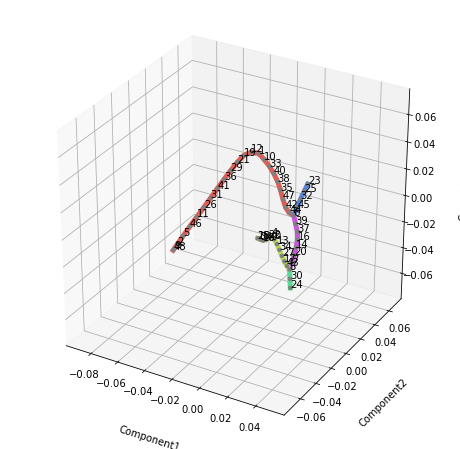

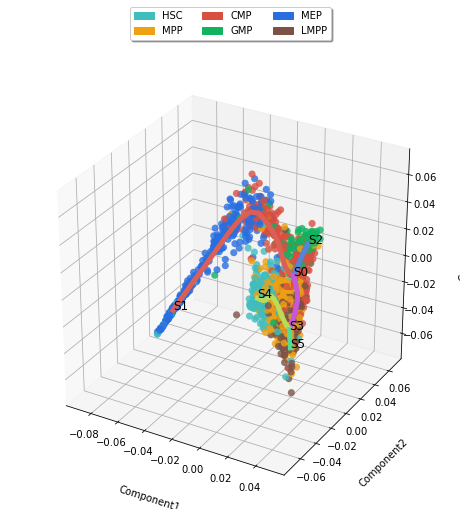

In [14]:
st.plot_branches(adata)
st.plot_branches_with_cells(adata)

Tips:  
- Add **'epg_trimmingradius'** will help get rid of noisy points (by defalut `epg_trimmingradius=Inf`)   
e.g. `st.optimize_branching(adata,epg_trimmingradius=0.1)`  

Optimizing branching...
[1]
 "Constructing tree 1 of 1 / Subset 1 of 1"


[1]
 "Computing EPG with 80 nodes on 1656 points and 3 dimensions"


[1]
 "Using a single core"


Nodes = 
50
 
51
 
52
 
53
 
54
 
55
 
56
 
57
 
58
 
59
 
60
 
61
 
62
 
63
 
64
 
65
 
66
 
67
 
68
 
69
 
70
 
71
 
72
 
73
 
74
 
75
 
76
 
77
 
78
 
79
 


BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

2||80
	
7.157e-05
	
80
	
79
	
74
	
2
	
0
	
0
	
4.513e-05
	
4.285e-05
	
0.9751
	
0.9764
	
2.029e-05
	
6.145e-06
	
0.0004916
	
0.03933
	
0


3.372 sec elapsed

Number of branches after optimizing branching: 5


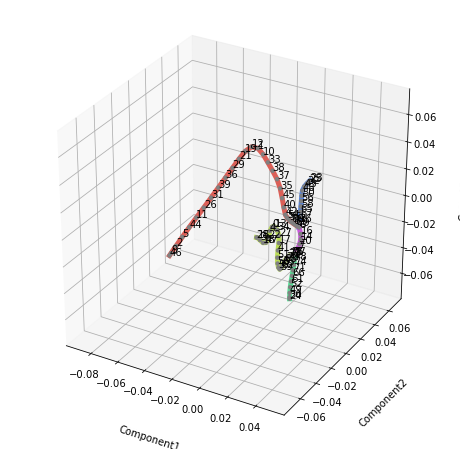

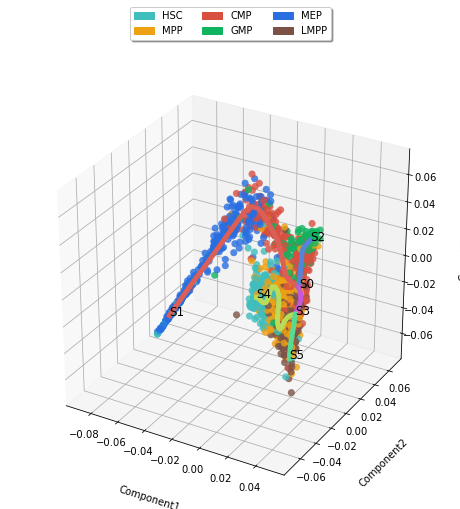

In [15]:
### optional step
st.optimize_branching(adata,epg_alpha=0.02,epg_mu=0.1,epg_lambda=0.01)
st.plot_branches(adata)
st.plot_branches_with_cells(adata)

Other optional steps:

- Prune branches:  
`st.prune_elastic_principal_graph?`  
`st.prune_elastic_principal_graph(adata)`


- Shift branching node:  
`st.shift_branching?`  
`st.shift_branching(adata)`

**check parameters**  
`st.extend_elastic_principal_graph?`  

Tips:  
- Add **'epg_trimmingradius'** will help get rid of noisy points (by defalut `epg_trimmingradius=Inf`)   
e.g. `st.extend_elastic_principal_graph(adata,epg_trimmingradius=0.1)`  

Extending leaves with additional nodes ...
Number of branches after extending leaves: 5


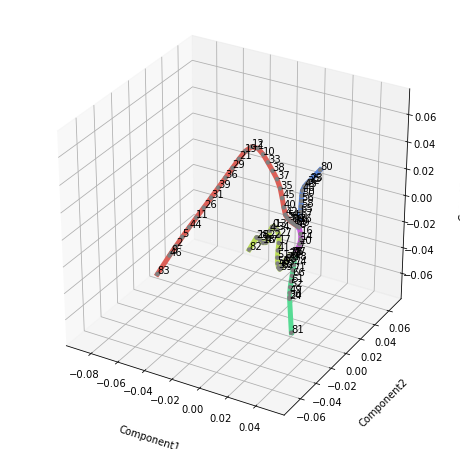

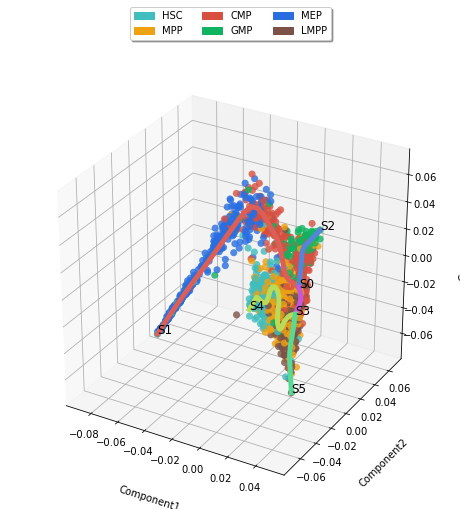

In [16]:
###Extend leaf branch to reach further cells 
st.extend_elastic_principal_graph(adata)
st.plot_branches(adata)
st.plot_branches_with_cells(adata)

/Users/huidong/anaconda3/envs/env_STREAM/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


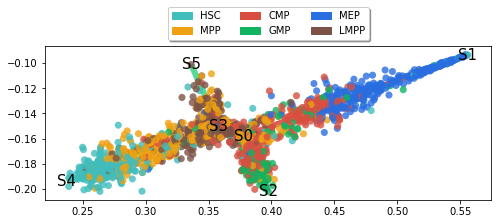

In [17]:
st.plot_flat_tree(adata)

Validate the learned structure by visualizing the branch assignment

Importing precomputed umap visualization ...
Importing precomputed umap visualization ...


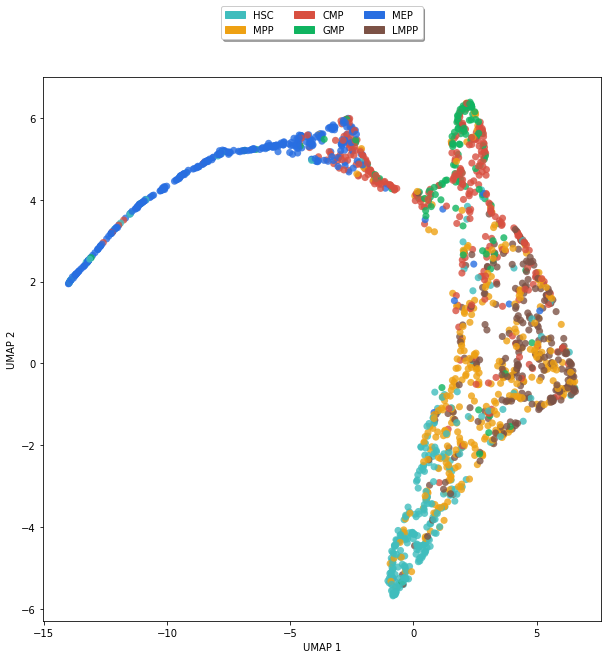

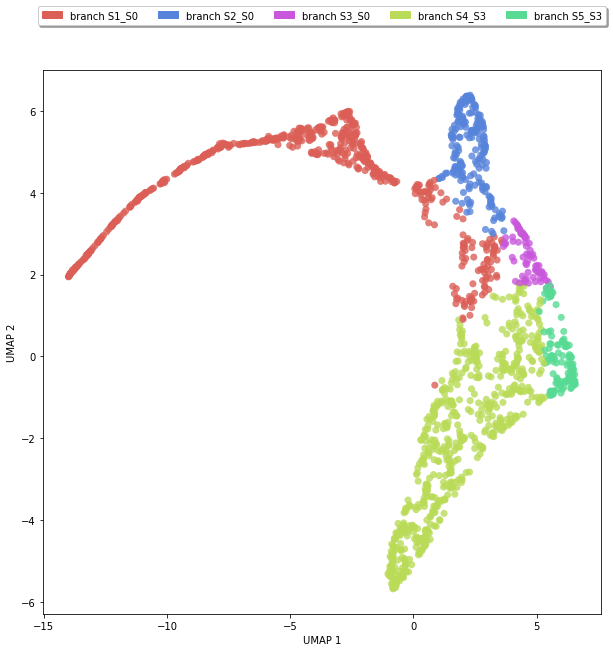

In [18]:
st.plot_visualization_2D(adata)
st.plot_visualization_2D(adata,color_by='branch',fig_legend_ncol=6)

**check parameters**  
`st.subwaymap_plot?`

By default **percentile_dist=95**, to make cells more conpact around the branches, try to **increase percentile_dist to beween 95 and 100**

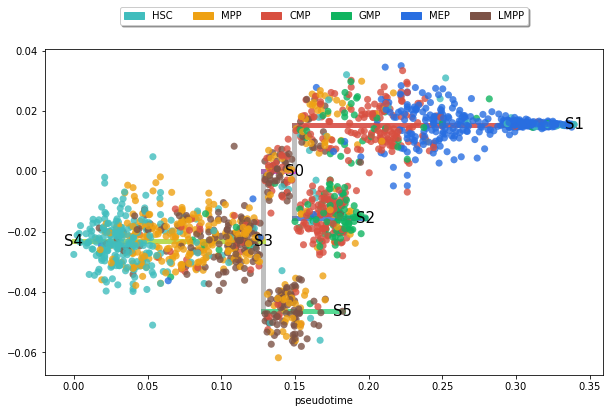

In [19]:
st.subwaymap_plot(adata,root='S4',fig_legend_ncol=6) 

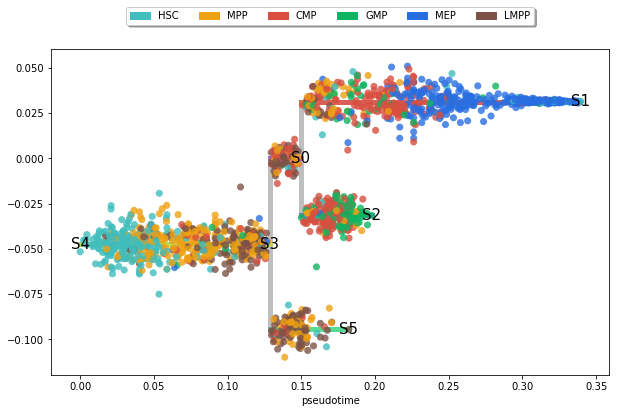

In [20]:
st.subwaymap_plot(adata,root='S4',fig_legend_ncol=6,percentile_dist=100) 

**check parameters**  
`st.stream_plot?`

By default **factor_min_win=2.0**, lowering it (between 1.0 and 2.0) can make smoother stream plot

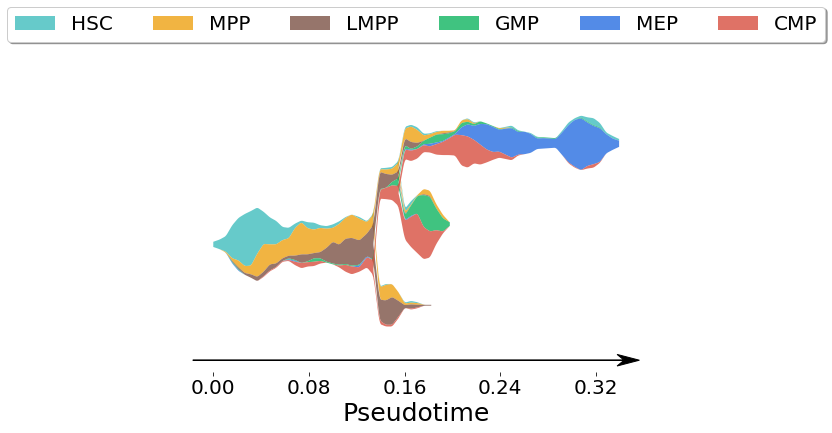

In [21]:
st.stream_plot(adata,root='S4',fig_legend_ncol=6,fig_size=(8,8))

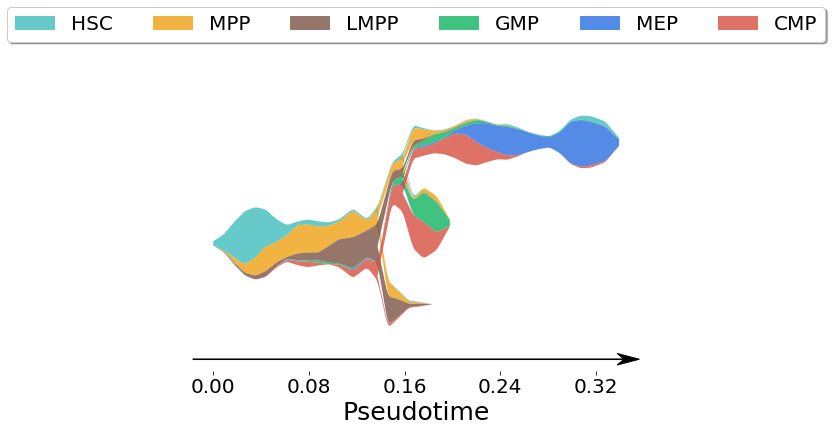

In [22]:
st.stream_plot(adata,root='S4',fig_legend_ncol=6,fig_size=(8,8),factor_min_win=1.2)

The order between **horizontal branches from the same parent node** has no meaning

Users can specify the order preference of nodes themselves by setting the parameter **'preference'**

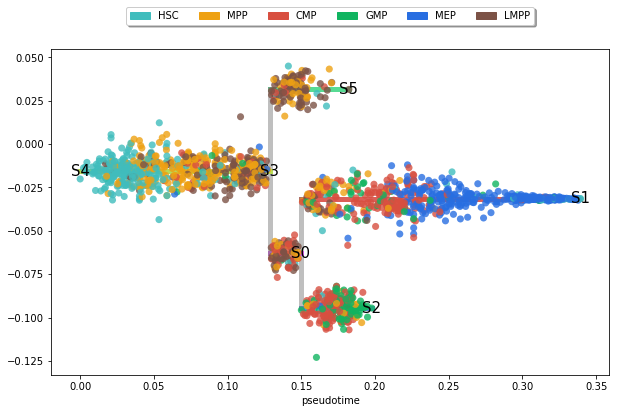

In [23]:
st.subwaymap_plot(adata,percentile_dist=100,root='S4',fig_legend_ncol=6,preference=['S5']) 

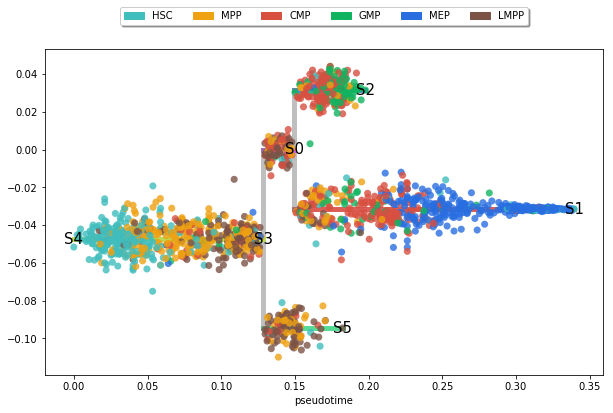

In [24]:
st.subwaymap_plot(adata,percentile_dist=100,root='S4',fig_legend_ncol=6,preference=['S2','S1']) 

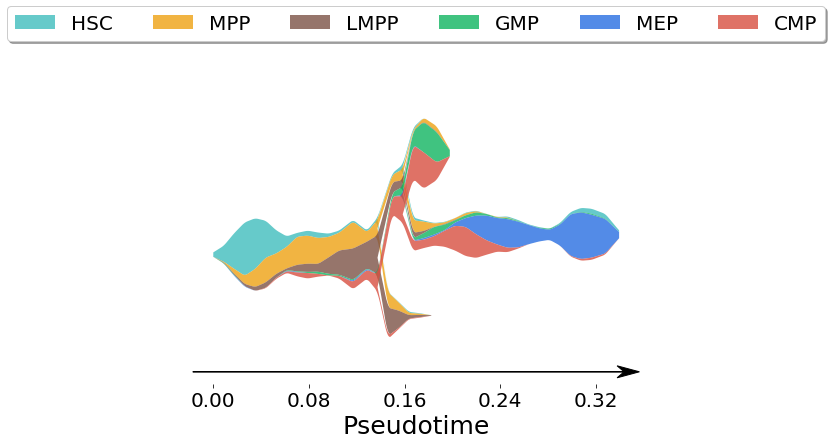

In [25]:
st.stream_plot(adata,root='S4',fig_legend_ncol=6,fig_size=(8,8),factor_min_win=1.2,preference=['S2','S1'])

For stream plot with **'thin branches'**, log2 view of stream plot (by specifying **'flag_log_view=True'**) will help zoom in the thin branches with very few cells by log2 transformation and visualize the composition of cells on the thin branches  
**factor_zoomin**: suggested value 50~200

**This case is best illustrated in tutorial** [4.STREAM_scATAC-seq](https://nbviewer.jupyter.org/github/pinellolab/STREAM/blob/master/tutorial/4.STREAM_scATAC-seq.ipynb)

<img src="./img/log2_view_plots.png" alt="log2_view_plots" width=1000>

#### Visualize genes

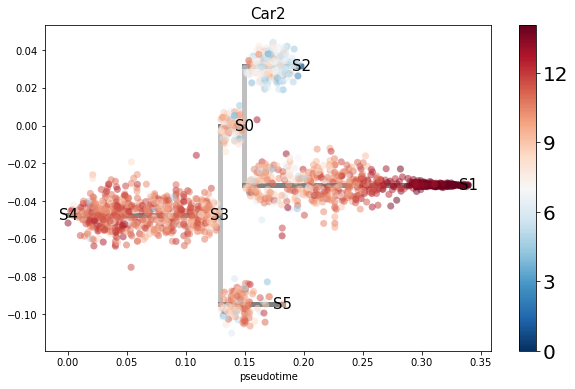

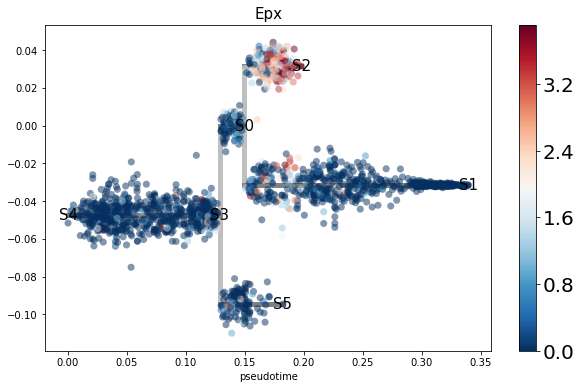

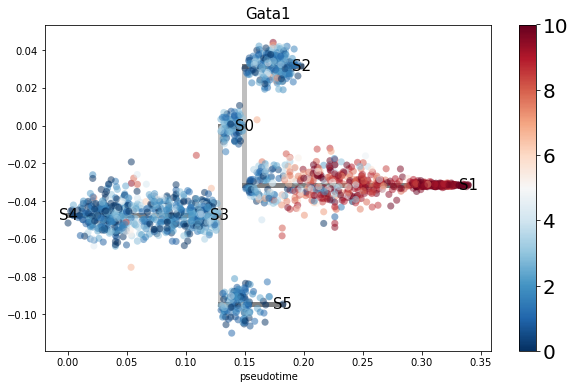

In [26]:
st.subwaymap_plot_gene(adata,percentile_dist=100,root='S4',preference=['S2','S1'],genes=['Gata1','Car2','Epx']) 

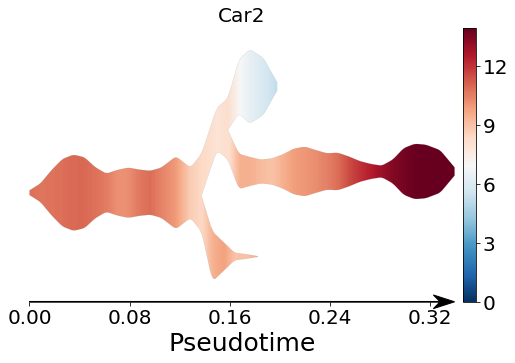

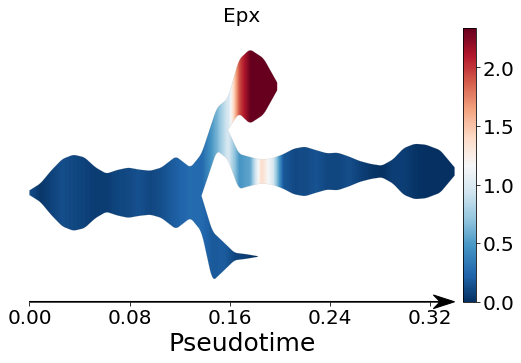

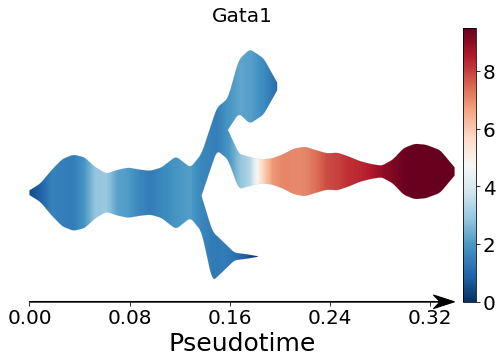

In [27]:
st.stream_plot_gene(adata,root='S4',fig_size=(8,8),factor_min_win=1.2,preference=['S2','S1'],genes=['Gata1','Car2','Epx'])

**Marker gene detection part is a bit time-consuming, so please make sure the struture learned from previous steps is reasonble before running any maker gene detection steps**

**Also it's not always necessary to execute all three marker gene detection parts. Running one of them might be adequate already.**

#### 1.Detect marker genes for each leaf branch

**'preference'** is only used to adjust the order of comparions (in coordance with subway_map plot and stream plot), it will not affect the final detected genes

In [28]:
st.detect_leaf_genes(adata,root='S4',preference=['S2','S1'],n_jobs=4)

Filtering out genes that are expressed in less than 5 cells ...
4 cpus are being used ...
4767 genes are being scanned ...


In [29]:
adata.uns['leaf_genes_all'].head()

,zscore,H_statistic,H_pvalue,S4S3_pvalue,S0S2_pvalue,S0S1_pvalue,S3S5_pvalue
Mfsd2b,1.726550,820.661303,1.429593e-177,4.168334e-215,3.296927e-122,1.000000e+00,4.945141e-108
Gata1,1.726341,773.889651,1.989927e-167,4.004661e-194,8.926326e-113,1.000000e+00,1.111103e-100
Mpl,1.679288,755.114258,2.347160e-163,1.000000e+00,4.892282e-147,2.813995e-180,2.509190e-52
Emb,-1.572322,730.051267,6.391342e-158,1.087062e-98,2.642417e-158,1.000000e+00,4.842050e-115
Vamp5,1.567642,726.623611,3.538987e-157,3.908042e-135,2.620785e-139,1.000000e+00,3.799880e-107


In [30]:
adata.uns['leaf_genes'].keys()

dict_keys([('S4', 'S3'), ('S0', 'S2'), ('S0', 'S1'), ('S3', 'S5')])

leaf branch S0_S1 genes

In [31]:
adata.uns['leaf_genes'][('S0','S1')]

,zscore,H_statistic,H_pvalue,S4S3_pvalue,S0S2_pvalue,S0S1_pvalue,S3S5_pvalue
Mfsd2b,1.726550,820.661303,1.429593e-177,4.168334e-215,3.296927e-122,1.0,4.945141e-108
Gata1,1.726341,773.889651,1.989927e-167,4.004661e-194,8.926326e-113,1.0,1.111103e-100
Emb,-1.572322,730.051267,6.391342e-158,1.087062e-98,2.642417e-158,1.0,4.842050e-115
Vamp5,1.567642,726.623611,3.538987e-157,3.908042e-135,2.620785e-139,1.0,3.799880e-107
Klf1,1.728245,672.693985,1.749243e-145,1.026235e-160,3.008581e-92,1.0,3.039519e-75
...,...,...,...,...,...,...,...
Pde5a,1.696844,18.339356,3.743550e-04,3.149900e-03,8.756993e-03,1.0,8.756993e-03
Sqrdl,1.698748,18.226732,3.949377e-04,5.657342e-03,6.567138e-03,1.0,7.343907e-03
Kyat1,1.600111,17.351301,5.983766e-04,6.974905e-03,6.974905e-03,1.0,6.974905e-03
6720464F23Rik,1.644759,17.148079,6.588707e-04,7.670397e-03,7.670397e-03,1.0,7.670397e-03


#### 2.Detect transition gene for each branch

In [32]:
st.detect_transistion_genes(adata,root='S4',preference=['S2','S1'])

Importing precomputed scaled gene expression matrix ...
4767 genes are being scanned ...


In [33]:
adata.uns['transition_genes'].keys()

dict_keys([('S4', 'S3'), ('S3', 'S0'), ('S0', 'S2'), ('S0', 'S1'), ('S3', 'S5')])

In [34]:
adata.uns['transition_genes'][('S4','S3')].head()

,stat,logfc,pval,qval
H2afy,0.790844,0.563427,2.151309e-135,6.281821e-132
Plac8,0.780536,1.340472,1.213772e-129,1.772107e-126
Flt3,0.719391,1.859241,5.399477e-101,5.255491e-98
Pdzk1ip1,-0.703447,1.723105,9.503932e-95,6.937870e-92
Cd34,0.696382,1.061910,4.110044e-92,2.400266e-89


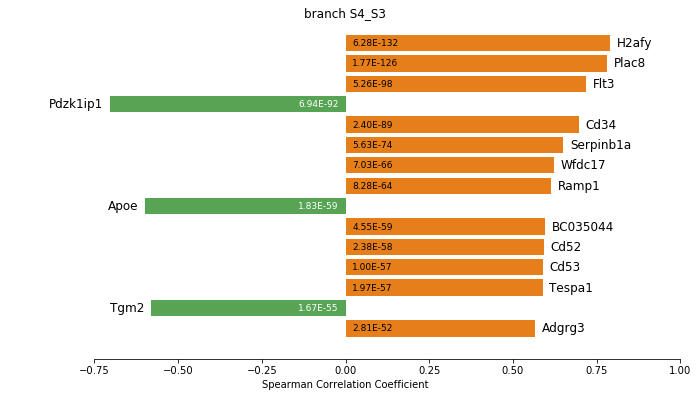

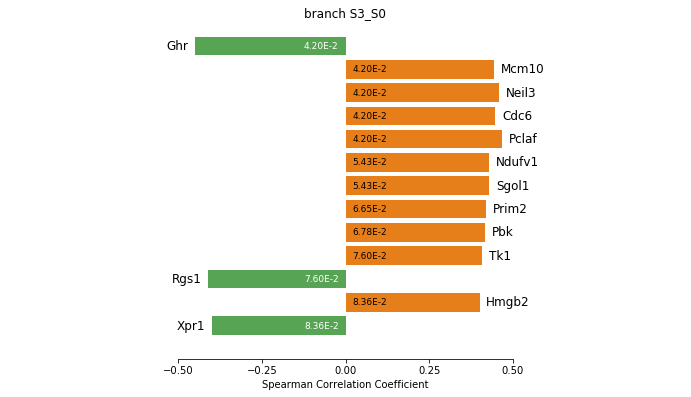

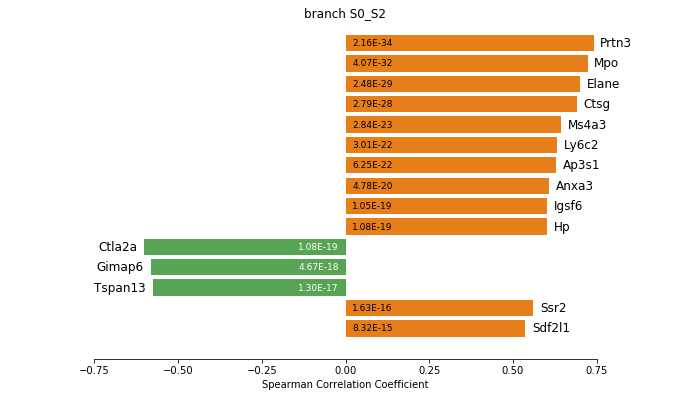

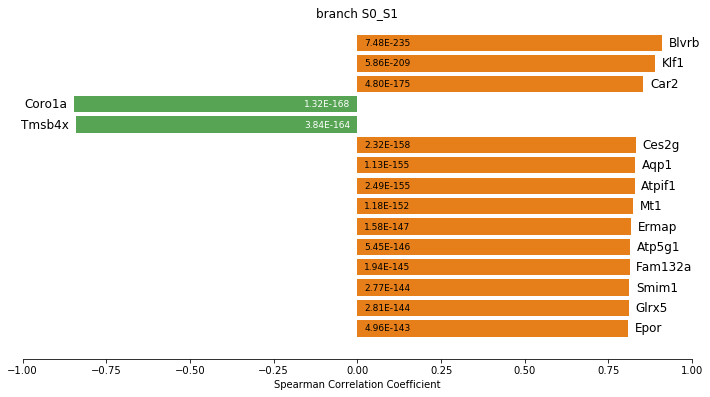

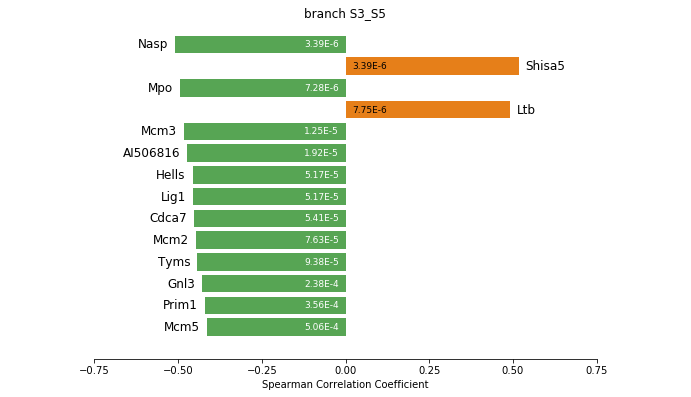

In [35]:
st.plot_transition_genes(adata)

#### 3.Detect differentially expressed genes between pairs of branches

In [36]:
st.detect_de_genes(adata,root='S4',preference=['S2','S1'])

Importing precomputed scaled gene expression matrix ...
4767 genes are being scanned ...


In [37]:
adata.uns['de_genes_greater'].keys()

dict_keys([(('S3', 'S0'), ('S0', 'S2')), (('S3', 'S0'), ('S0', 'S1')), (('S0', 'S2'), ('S0', 'S1')), (('S4', 'S3'), ('S3', 'S0')), (('S4', 'S3'), ('S3', 'S5')), (('S3', 'S0'), ('S3', 'S5'))])

In [38]:
adata.uns['de_genes_less'].keys()

dict_keys([(('S3', 'S0'), ('S0', 'S2')), (('S3', 'S0'), ('S0', 'S1')), (('S0', 'S2'), ('S0', 'S1')), (('S4', 'S3'), ('S3', 'S0')), (('S4', 'S3'), ('S3', 'S5')), (('S3', 'S0'), ('S3', 'S5'))])

* Genes that are highly expressed on branch **S0_S2** when comparing branch S0_S2 and branch S0_S1

In [39]:
adata.uns['de_genes_greater'][(('S0', 'S2'), ('S0', 'S1'))].head()

,z_score,U,logfc,mean_up,mean_down,pval,qval
Epx,20.814324,117806.5,3.277999,0.567965,0.058043,3.223744e-96,8.372064e-93
Prtn3,20.740057,127731.0,1.236466,0.931197,0.394674,1.512696e-95,1.964236e-92
Mpo,20.553313,127169.0,1.029837,0.938832,0.459328,7.213211e-94,6.244236e-91
Ctsg,20.338625,126526.0,1.495212,0.916498,0.324516,5.874742e-92,3.814177e-89
Emb,19.543130,124155.0,1.375453,0.877600,0.337715,4.735085e-85,2.459403e-82


* Genes that are highly expressed on branch **S0_S1** when comparing branch S0_S2 and branch S0_S1

In [40]:
adata.uns['de_genes_less'][(('S0', 'S2'), ('S0', 'S1'))].head()

,z_score,U,logfc,mean_up,mean_down,pval,qval
Car2,-19.391730,6947.0,0.795514,0.464165,0.806244,9.093006e-84,2.951817e-81
Vamp5,-18.928559,8341.0,0.774956,0.508572,0.870856,6.656250e-80,1.728628e-77
Mfsd2b,-18.288934,10261.5,1.657128,0.243023,0.768123,1.016880e-74,1.650523e-72
Gata1,-17.703939,12021.0,1.926282,0.193539,0.737659,3.921311e-70,5.091823e-68
Slc14a1,-16.773064,14823.0,1.448018,0.266802,0.729185,3.852534e-63,3.335010e-61


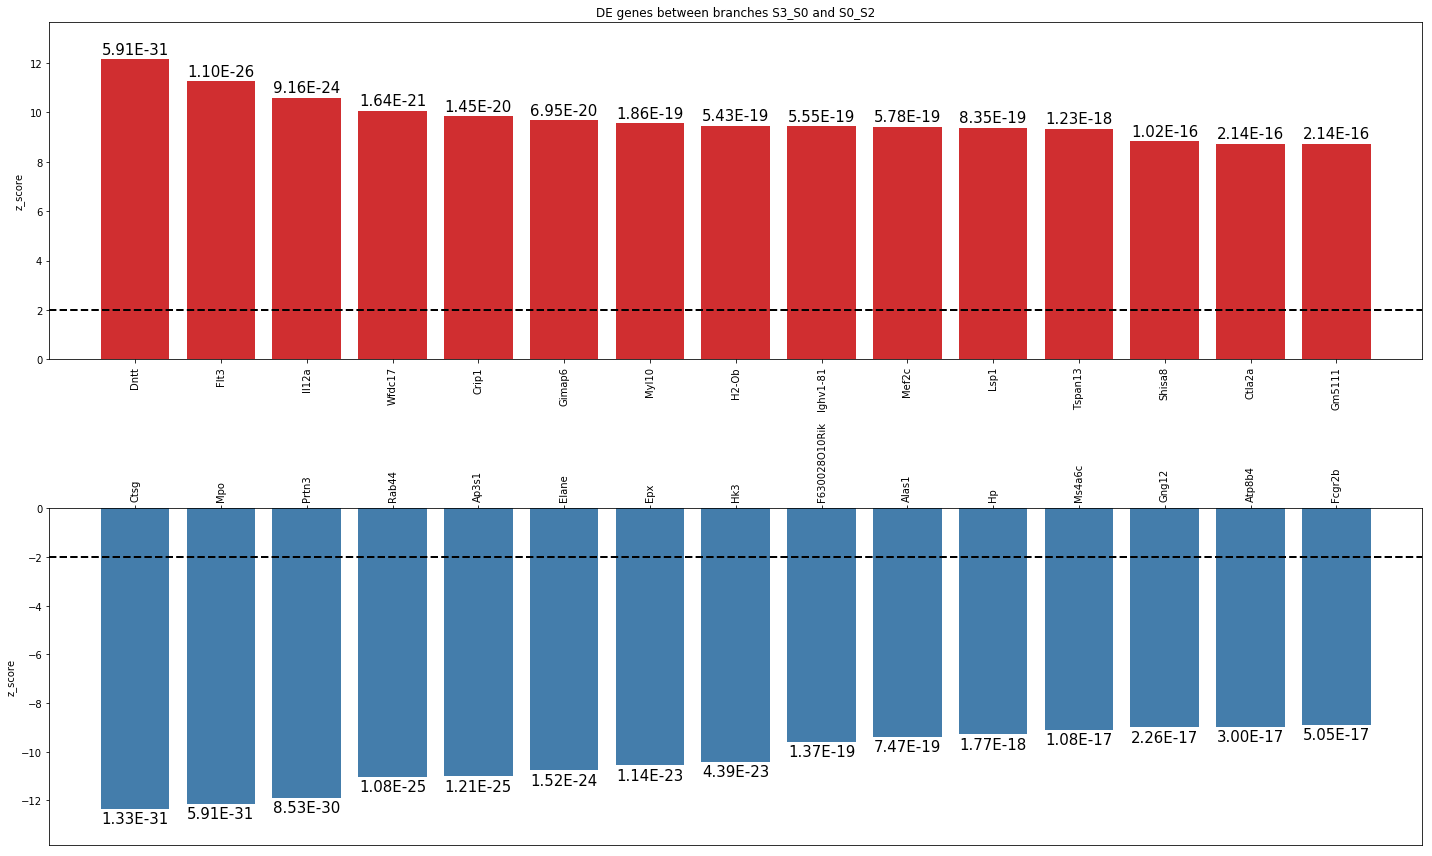

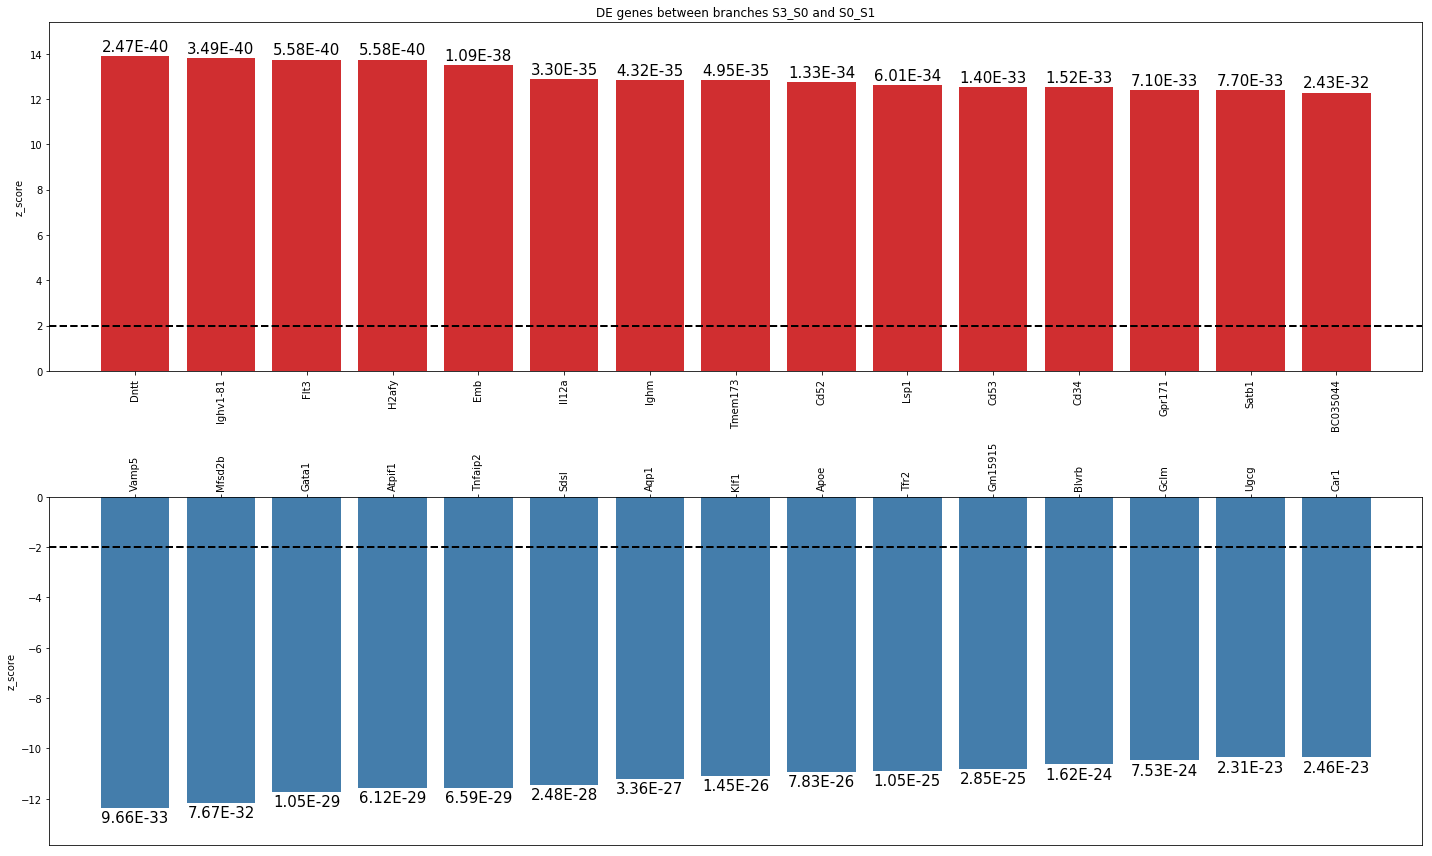

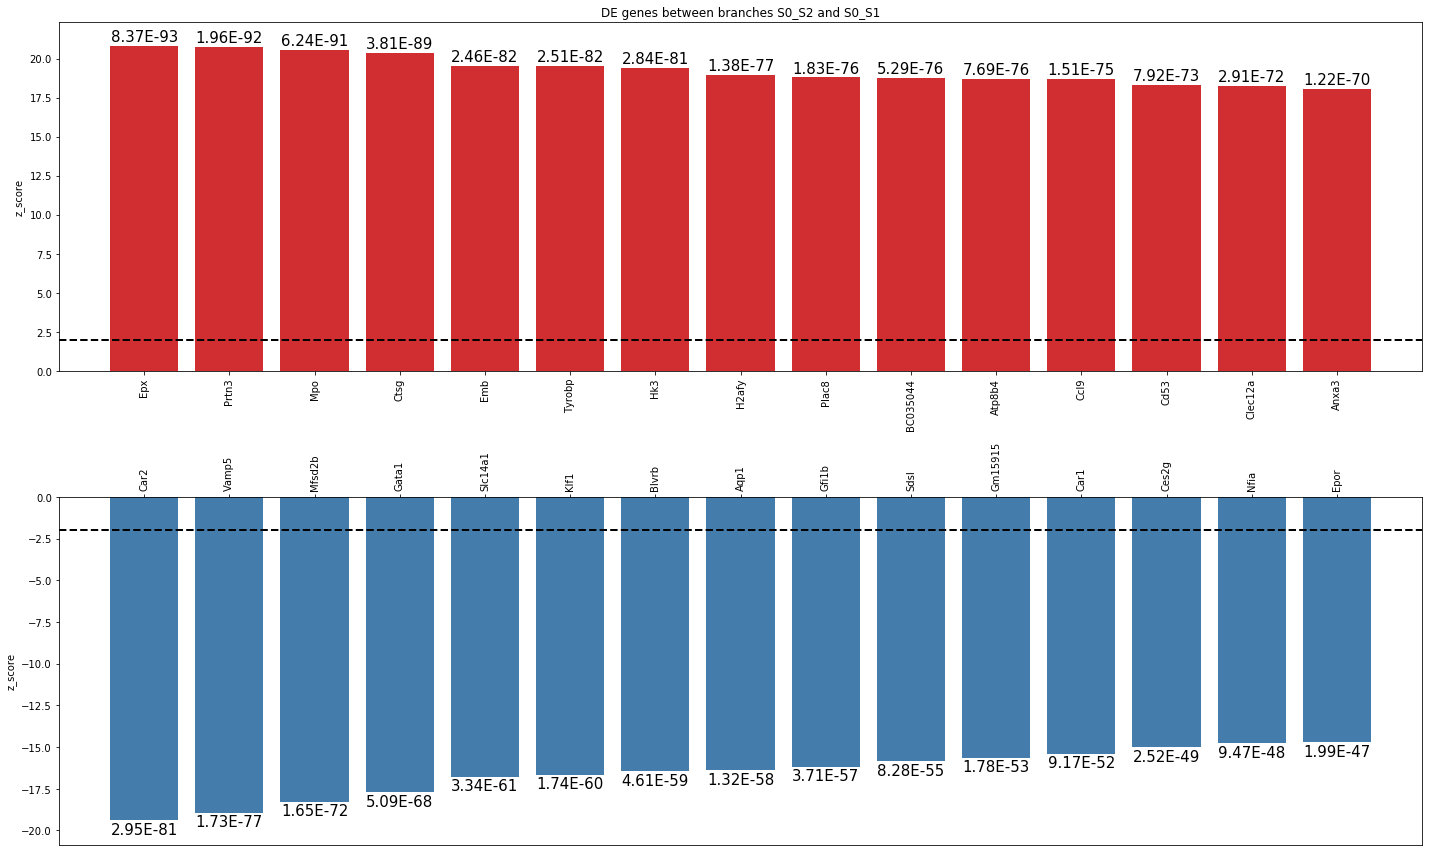

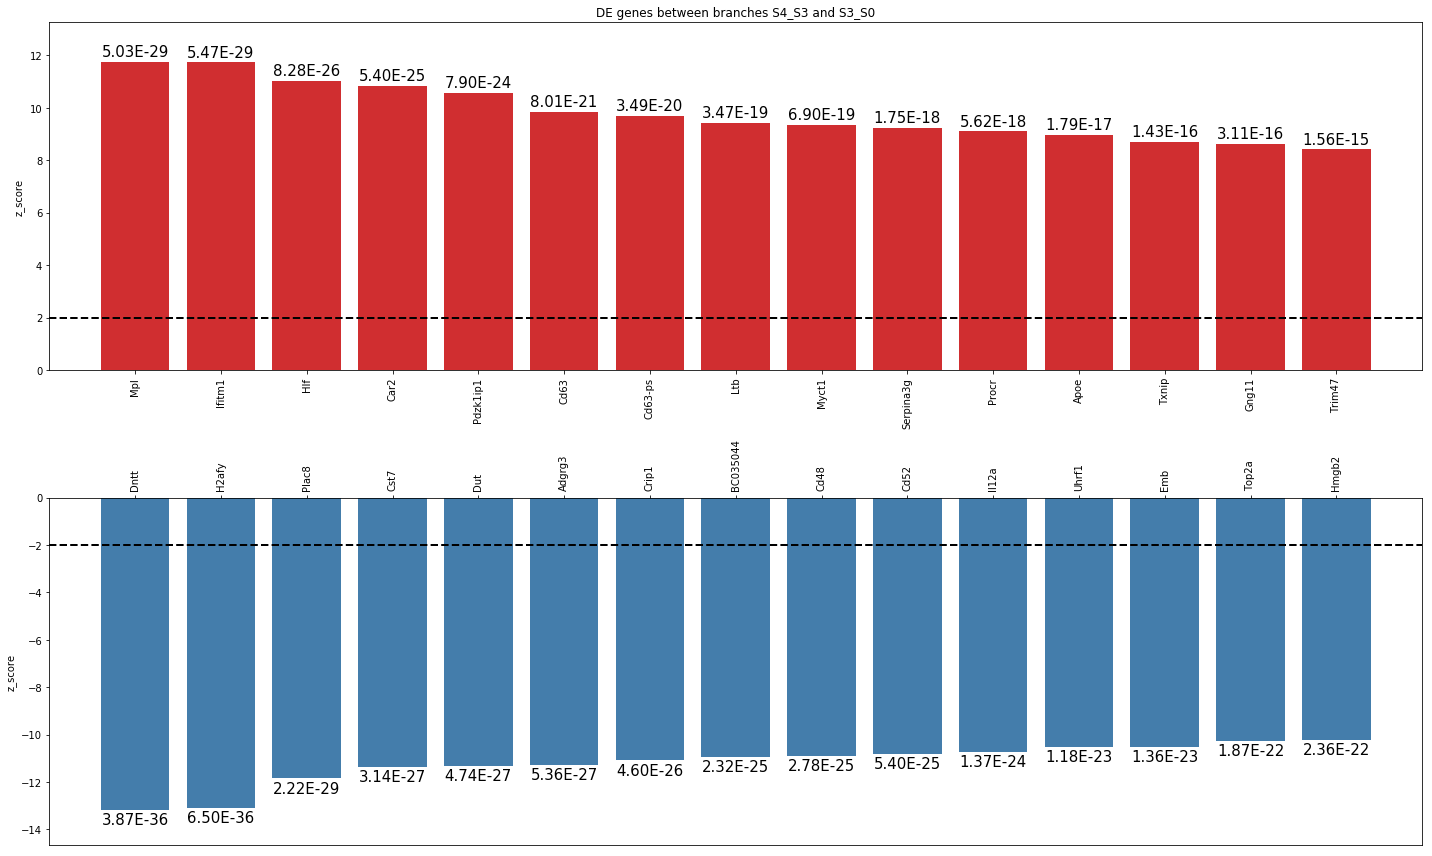

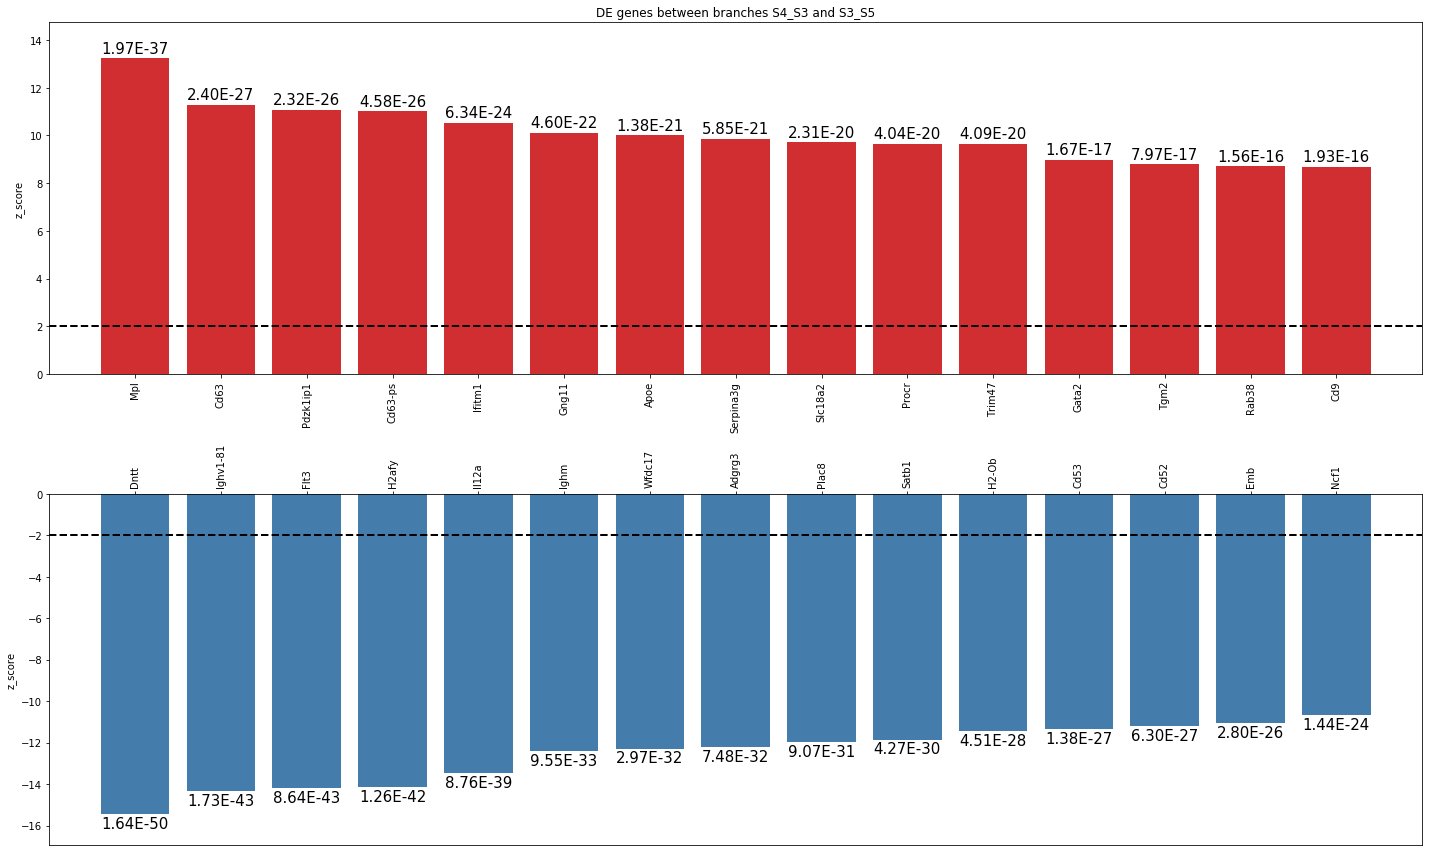

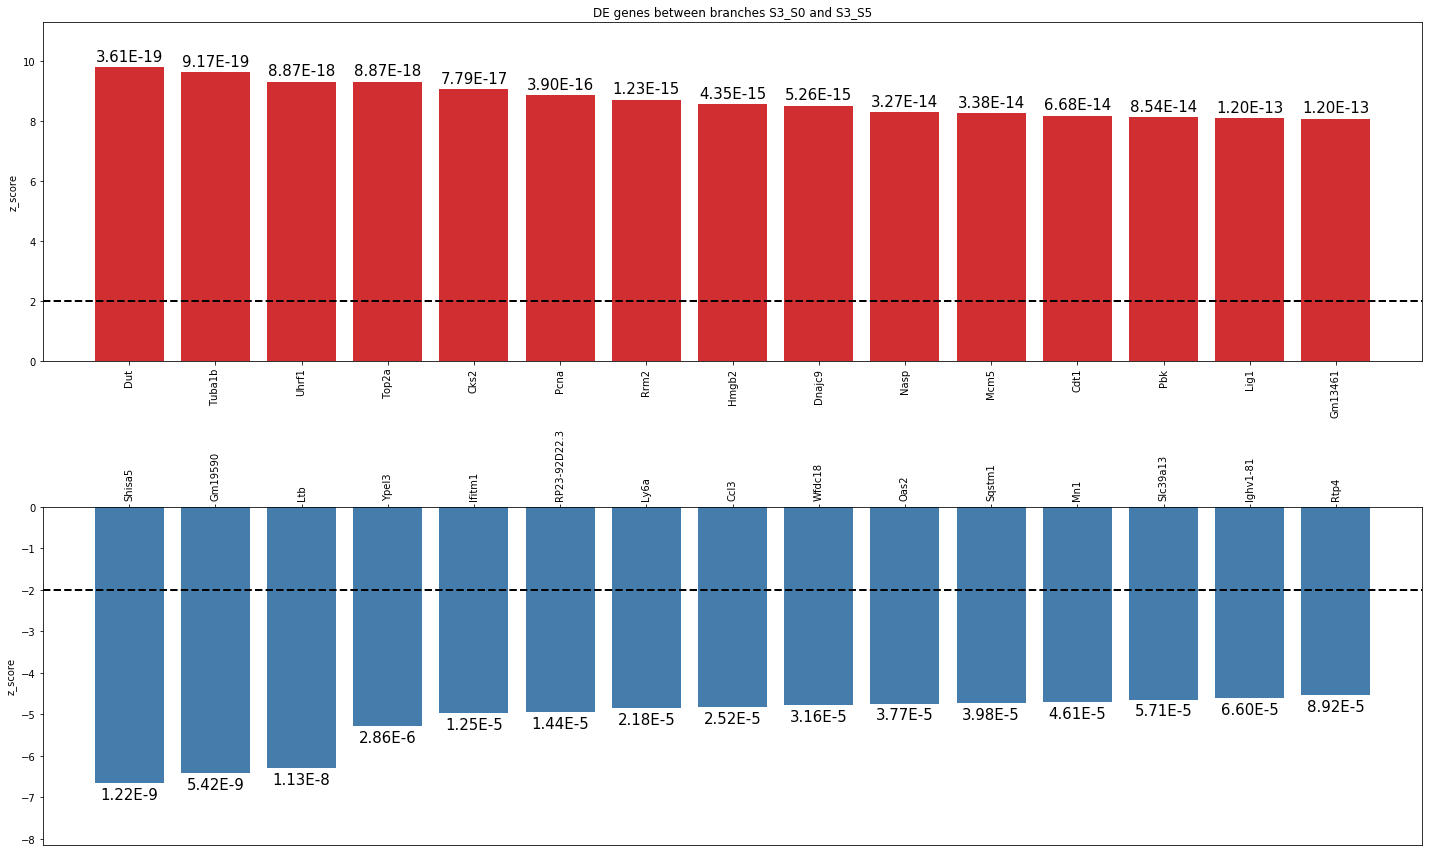

In [41]:
st.plot_de_genes(adata)

In [42]:
adata

AnnData object with n_obs × n_vars = 1656 × 4762 
    obs: 'label', 'label_color', 'node', 'branch_id', 'branch_id_alias', 'branch_lam', 'branch_dist', 'S0_pseudotime', 'S3_pseudotime', 'S2_pseudotime', 'S5_pseudotime', 'S4_pseudotime', 'S1_pseudotime'
    var: 'n_counts', 'n_cells'
    uns: 'experiment', 'workdir', 'label_color', 'var_genes', 'trans_mlle', 'epg', 'flat_tree', 'seed_epg', 'seed_flat_tree', 'ori_epg', 'epg_obj', 'ori_epg_obj', 'subwaymap_S4', 'scaled_gene_expr', 'leaf_genes_all', 'leaf_genes', 'transition_genes', 'de_genes_greater', 'de_genes_less'
    obsm: 'var_genes', 'X_mlle', 'X_dr', 'X_vis_umap', 'X_spring', 'X_subwaymap_S4'

In [43]:
adata.obs.head()

,label,label_color,node,branch_id,branch_id_alias,branch_lam,branch_dist,S0_pseudotime,S3_pseudotime,S2_pseudotime,S5_pseudotime,S4_pseudotime,S1_pseudotime
HSPC_025,MPP,#eea113,68,"(82, 8)","(S4, S3)",0.110399,0.002971,0.039219,0.018161,0.087398,0.071878,0.110399,0.228986
HSPC_031,MPP,#eea113,63,"(82, 8)","(S4, S3)",0.105702,0.000822,0.043916,0.022858,0.092095,0.076575,0.105702,0.233682
HSPC_037,MPP,#eea113,66,"(81, 8)","(S5, S3)",0.038840,0.004198,0.035934,0.014876,0.084113,0.038840,0.143437,0.225700
LT-HSC_001,HSC,#40bdbd,18,"(82, 8)","(S4, S3)",0.035099,0.009775,0.114519,0.093461,0.162698,0.147177,0.035099,0.304285
HSPC_001,MPP,#eea113,47,"(82, 8)","(S4, S3)",0.041148,0.008329,0.108471,0.087413,0.156650,0.141129,0.041148,0.298237


#### Additionally, STREAM can be also used to detect cell population-specific markers

In [44]:
st.find_marker(adata,ident='label')

Importing precomputed scaled gene expression matrix ...
4767 genes are being scanned ...


In [45]:
adata.uns['markers_label_all'].head()

,zscore,H_statistic,H_pvalue,CMP,GMP,HSC,LMPP,MEP,MPP
Atpif1,1.87094,893.907,5.54241e-191,8.12348e-73,8.26153e-35,6.36718e-217,1.03423e-177,-1,1.41084e-178
Cd34,-1.85017,834.97,3.14343e-178,2.6501e-119,1.03478e-65,1.29655e-25,4.91601e-188,-1,3.61009e-174
Cdk6,-1.75754,800.812,7.72125e-171,3.7432e-161,6.48728e-103,-1,8.91453e-19,3.34392e-137,6.06012e-21
Plac8,-1.58746,757.48,1.82323e-161,2.68676e-147,8.70888e-132,-1,2.21129e-67,1.54719e-10,2.16437e-50
Coro1a,-2.17012,750.798,5.08357e-160,2.22162e-104,2.9121e-58,3.11579e-86,6.90204e-166,-1,9.57623e-170


In [46]:
adata.uns['markers_label'].keys()

dict_keys(['CMP', 'GMP', 'HSC', 'LMPP', 'MEP', 'MPP'])

In [47]:
adata.uns['markers_label']['MEP'].head()

,zscore,H_statistic,H_pvalue,CMP,GMP,HSC,LMPP,MPP
Atpif1,1.87094,893.907,5.54241e-191,8.12348e-73,8.26153e-35,6.36718e-217,1.03423e-177,1.41084e-178
Cd34,-1.85017,834.97,3.14343e-178,2.6501e-119,1.03478e-65,1.29655e-25,4.91601e-188,3.61009e-174
Coro1a,-2.17012,750.798,5.08357e-160,2.22162e-104,2.9121e-58,3.11579e-86,6.90204e-166,9.57623e-170
Tmsb4x,-2.17607,738.786,2.01398e-157,3.64224e-160,2.45213e-145,5.24951e-72,2.48956e-87,2.65594e-106
Ifitm1,-1.89313,729.175,2.41235e-155,1.30812e-42,6.45965e-22,4.64442e-161,3.9322e-93,2.06523e-146


#### Save results

save `adata` to `.pkl` file (by default, it's named `stream_result.pkl`)

In [48]:
st.write(adata)

Read back the saved pkl file
```python
adata = st.read('./stream_result/stream_result.pkl',file_format='pkl',workdir='./stream_result')
```

#### Save web report (Optional)

Save the analysis result and interactively visualize it on STREAM website (http://stream.pinellolab.org/) or local STREAM_web docker image (https://github.com/pinellolab/STREAM_web)

**check parameters**  
`st.save_web_report?`

Generating coordinates of cells in 3D plots...
Generating coordinates of curves in 3D plots...
Generating coordinates of states/nodes in 3D plots...
Generating coordinates of cells in flat tree...
Generating coordinates of flat tree...
Generating subway map plots and stream plots of cells...
Generating transition genes...
Generating DE genes...
Generating leaf genes...
Visualizing 59 genes from detected top marker genes...
Generating subway map plots and stream plots of genes...
Zipping the files...
Done!


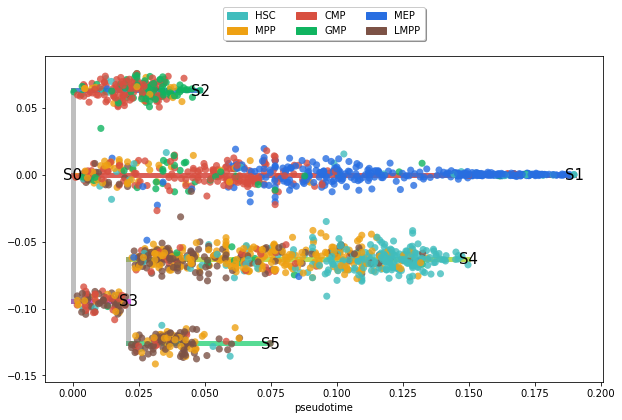

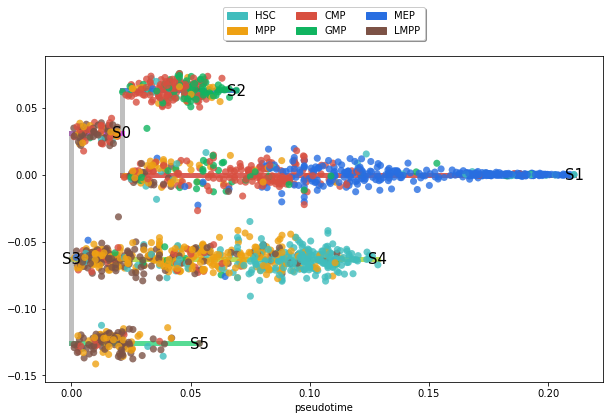

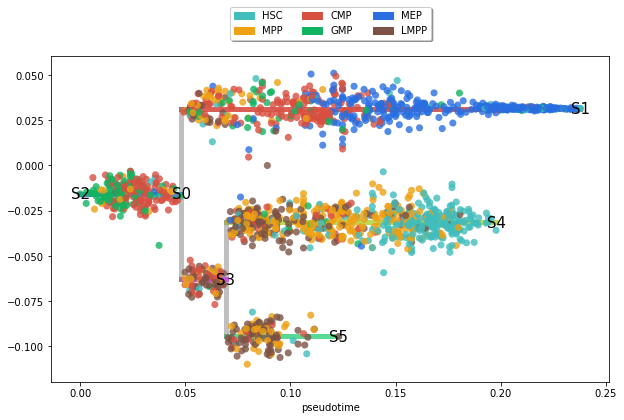

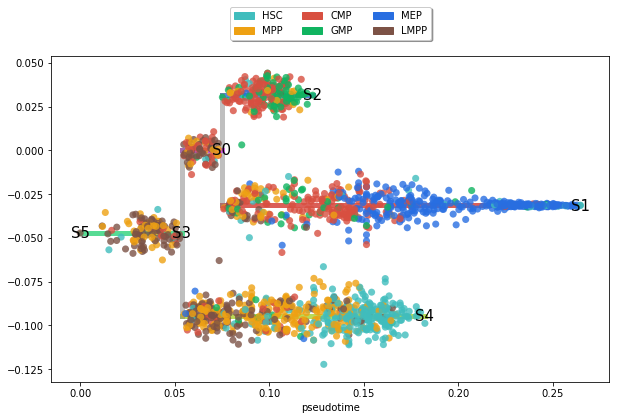

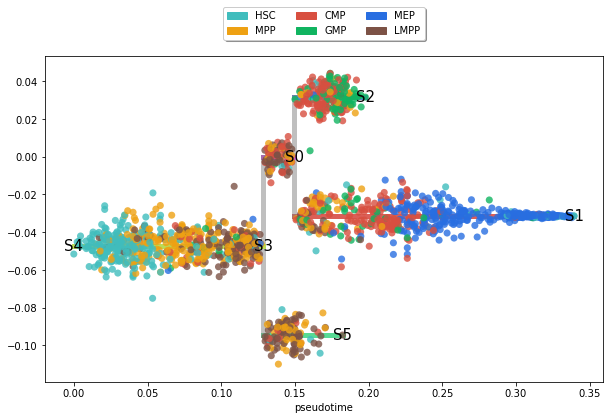

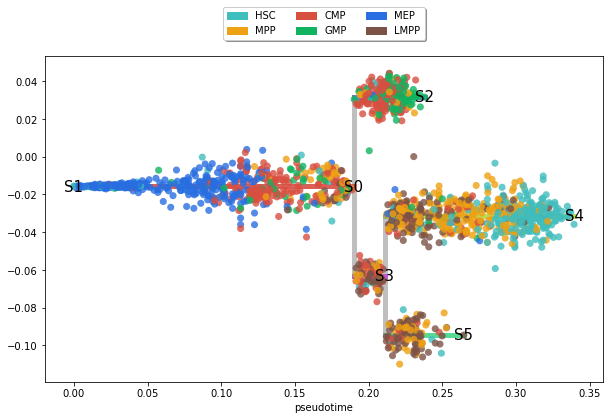

In [49]:
st.save_web_report(adata,fig_size=(8,8),n_genes=5,preference=['S2','S1'],factor_min_win=1.2,
                title='Nestorowa, S. et al. 2016',
                description='This scRNA-seq dataset contains 1656 cells and 4768 genes from mouse hematopoietic stem and progenitor cell differentiation. A single-cell resolution map of mouse hematopoietic stem and progenitor cell differentiation. Blood 128, e20-31 (2016).',
                starting_node='S4',command_used='1.STREAM_scRNA-seq (in 3D space)')